In [1]:
import numpy as np
from utils.fw import FW_parallel
from utils.cluster_jet import cluster_data

# compute FW and cluster jets

In [2]:
nb_data = 1000
ww = np.load('./data/ww_4j_train_arr.npy')[:nb_data]
zz = np.load('./data/zz_4j_train_arr.npy')[:nb_data]

In [3]:
nb_jets = 4 ## cluster nb_jets using ee-kt
nb_fw = 10 ## compute the first nb_fw FW-moments
n_jobs = -1 ## using all cores to compute

ww_jet = cluster_data(ww, nb_jets=nb_jets, n_jobs=n_jobs)
ww_fw = FW_parallel(ww, lmax=nb_fw, n_jobs=n_jobs)
zz_jet = cluster_data(zz, nb_jets=nb_jets, n_jobs=n_jobs)
zz_fw = FW_parallel(zz, lmax=nb_fw, n_jobs=n_jobs)

# train and save model

In [4]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

from utils.data_loader import get_data_J2
from utils.train_func import train_J2_model
from models.fc_mdoels import J2_net

In [5]:
num_epochs = 10
batch_size = 256
test_size = 0.2
lr = 0.001
layers = [16, 128, 128, 128, 16]
use_gpu = True


device = torch.device('cuda:0') if use_gpu else torch.device('cpu')

dataloaders = get_data_J2(sig=zz_jet, 
                       bg=ww_jet, 
                       sigfw=zz_fw,
                       bgfw=ww_fw,
                       batch_size=batch_size, 
                       test_size=test_size,
                       use_gpu=use_gpu)
criterion = torch.nn.BCELoss()
model = J2_net(layers=layers, indim=4*nb_jets, nb_fw=nb_fw)
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             betas=(0.9, 0.999),
                             eps=1e-08,
                             weight_decay=1e-5)
model, history = train_J2_model(model=model, 
                             dataloaders=dataloaders, 
                             criterion=criterion, 
                             optimizer=optimizer, 
                             num_epochs=num_epochs, 
                             device=device)
torch.save(model.state_dict(), 'saved_model/J2_model.pt')

Epoch 0/9
Epoch Loss: 0.694355, Acc: 0.493750, Val Loss: 0.694389, Val Acc: 0.477500
----------
Epoch 1/9
Epoch Loss: 0.692463, Acc: 0.507500, Val Loss: 0.694113, Val Acc: 0.485000
----------
Epoch 2/9
Epoch Loss: 0.691557, Acc: 0.514375, Val Loss: 0.693841, Val Acc: 0.475000
----------
Epoch 3/9
Epoch Loss: 0.689868, Acc: 0.533750, Val Loss: 0.693193, Val Acc: 0.497500
----------
Epoch 4/9
Epoch Loss: 0.687692, Acc: 0.543125, Val Loss: 0.692423, Val Acc: 0.515000
----------
Epoch 5/9
Epoch Loss: 0.685051, Acc: 0.543125, Val Loss: 0.691115, Val Acc: 0.525000
----------
Epoch 6/9
Epoch Loss: 0.680316, Acc: 0.543750, Val Loss: 0.689192, Val Acc: 0.537500
----------
Epoch 7/9
Epoch Loss: 0.673956, Acc: 0.564375, Val Loss: 0.683058, Val Acc: 0.562500
----------
Epoch 8/9
Epoch Loss: 0.662511, Acc: 0.593125, Val Loss: 0.671652, Val Acc: 0.567500
----------
Epoch 9/9
Epoch Loss: 0.645255, Acc: 0.625000, Val Loss: 0.654913, Val Acc: 0.585000
----------
Training complete in 0m 8s


# visualize training

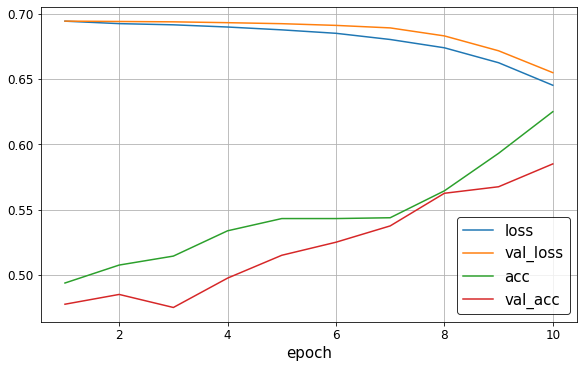

In [6]:
plot_params = {
    'linewidth': 1.5,
    'alpha': 1,
}

fig, ax = plt.subplots(1, 1, figsize=(8, 5), constrained_layout=True)
for key in history:
    ax.plot([x + 1 for x in range(num_epochs)], history[key], label=key, **plot_params)
ax.legend(loc='best', fontsize=15, edgecolor='k')
ax.set_xlabel('epoch', fontsize=15)
ax.grid(True)
ax.tick_params(labelsize=12)
plt.show()

# load model and evaluate

In [7]:
nb_data = 100
zz_test = np.load('./data/zz_4j_test_arr.npy')[:nb_data]
ww_test = np.load('./data/ww_4j_test_arr.npy')[:nb_data]

In [8]:
ww_jet_test = cluster_data(ww_test, nb_jets=nb_jets, n_jobs=n_jobs)
ww_fw_test = FW_parallel(ww_test, lmax=nb_fw, n_jobs=n_jobs)
zz_jet_test = cluster_data(zz_test, nb_jets=nb_jets, n_jobs=n_jobs)
zz_fw_test = FW_parallel(zz_test, lmax=nb_fw, n_jobs=n_jobs)

In [9]:
net = J2_net(layers=layers, indim=nb_jets*4, nb_fw=nb_fw)
net.load_state_dict(torch.load('./saved_model/J2_model.pt'))
net.eval()

sig_out = net(
    torch.from_numpy(zz_jet_test).float(),
    torch.from_numpy(zz_fw_test).float()
    ).detach().cpu().numpy()
bg_out = net(
    torch.from_numpy(ww_jet_test).float(),
    torch.from_numpy(ww_fw_test).float()
    ).detach().cpu().numpy()

# visualize distribution and ROC

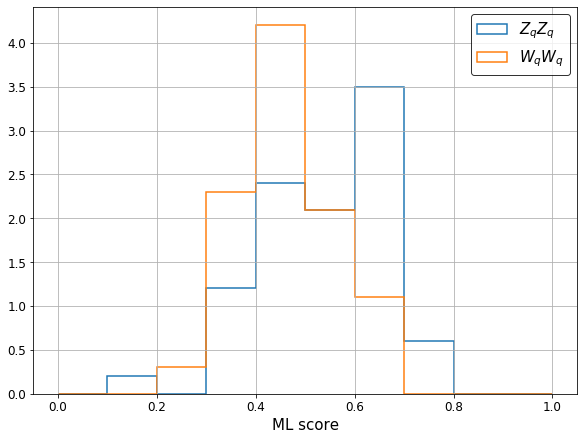

In [10]:
plot_params = {
    'bins': 10,
    'range': (0, 1),
    'linewidth': 1.5,
    'histtype': 'step',
    'alpha': 1,
    'density': True
}

fig, ax = plt.subplots(1, 1, figsize=(8, 6), constrained_layout=True)
ax.hist(sig_out, label=r'$Z_qZ_q$', **plot_params)
ax.hist(bg_out, label=r'$W_qW_q$', **plot_params)
ax.legend(loc='best', fontsize=15, edgecolor='k')
ax.set_xlabel('ML score', fontsize=15)
ax.grid(True)
ax.tick_params(labelsize=12)
plt.show()

In [11]:
from sklearn.metrics import roc_auc_score, roc_curve

y_true = np.concatenate((np.ones(len(sig_out)), np.zeros(len(bg_out))), axis=0)
y_pred = np.concatenate((sig_out, bg_out), axis=0)
auc = roc_auc_score(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_pred)

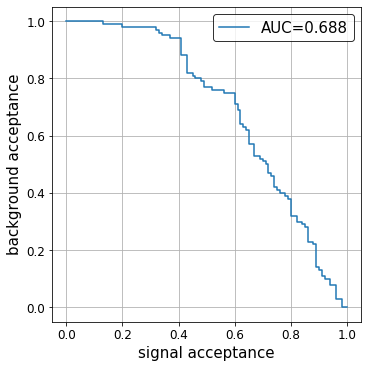

In [12]:
plot_params = {
    'linewidth': 1.5,
    'alpha': 1,
}

fig, ax = plt.subplots(1, 1, figsize=(5, 5), constrained_layout=True)
ax.plot(tpr, 1-fpr, label='AUC=%.3f'%auc, **plot_params)
ax.legend(loc='best', fontsize=15, edgecolor='k')
ax.set_xlabel('signal acceptance', fontsize=15)
ax.set_ylabel('background acceptance', fontsize=15)
ax.grid(True)
ax.tick_params(labelsize=12)
plt.show()